In [2]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import h5py
import matplotlib.pyplot as plt
import matplotlib.dates as md
from scipy.optimize import leastsq,curve_fit
import math
import time
import datetime as dt

In [3]:
def open_data(exp_id):
    ## basic paths
    data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
    analysis_local_path='D:/Analysis/' # D:\ is local SSD in the main experiment computer
    analysis_master_path='Y:/Analysis/' # Y:\ is network drive connected to Hexagon E:\Rb\
    experiment_file='results.hdf5'
    qdp_name='qdp.txt'

    exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
    exp_path=data_master_path+exp_date+'/'+exp_id+'/'
    analysis_path=analysis_master_path+exp_date+'/'+exp_id+'/'

    if not os.path.exists(analysis_path):
        os.makedirs(analysis_path)

    if os.path.isfile(analysis_path+qdp_name):
        print "Yay! found old qdp class. We can save time!"
        q = qdp.load_qdp(filename=analysis_path+qdp_name)
    else:
        print "Coudn't find processed qdp. Loading and saving"
        q = qdp.QDP(base_data_path=exp_path)
        q.load_data_file(experiment_file)
        q.save_qdp(filename=analysis_path+qdp_name)
    return q

def process_container(exp_id):
    q=open_data(exp_id)
    cuts=[[450],[450],[450]]
    for r in range(5):
        q.set_thresholds(cuts, roi=r)
    xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
    retention = q.apply_thresholds()
    
    e=0
    timestamp=[]
    xdata=[]
    reten={}
    err={}
    container={}
    for i in q.experiments[e]['iterations']:
        iter_timestamp=q.experiments[e]['iterations'][i]['timestamp_iteration']
        timestamp.append(iter_timestamp)
        xdata.append(np.squeeze(retention['ivar'])[i][0])
        for roi in [0,1,2,3,4]:
            if i==0:
                reten[str(roi)]=[]
                err[str(roi)]=[]
            reten[str(roi)].append(np.squeeze(retention['retention'])[i][roi])
            err[str(roi)].append(np.squeeze(retention['error'])[e][roi])

    dates=[dt.datetime.fromtimestamp(ts) for ts in timestamp]
    container['exp_id']=exp_id
    container['timestamps']=timestamp
    container['datetime']=dates
    container['xdata']=xdata
    container['retentions']=reten
    container['errors']=err
    return container

def flatten(l):
    flat_list = [item for sublist in l for item in sublist]
    return flat_list


def sin(t,amp,freq,phase,offset):
    res = (amp*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def decaying_sin(t,tau,amp,freq,phase,offset):
    res = (amp*np.exp(-t/tau)*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def est_freq(ydata,tgap,tau,amp,freq,phase,offset): # Estimation of frequency change (from dy/df where y=sinusoidal fit)
    res=(ydata-decaying_sin(tau,tgap,amp,freq,phase,offset))/(amp*np.exp(-tgap/tau)*2*np.pi*tgap*np.cos(2*np.pi*freq*tgap+phase))
    return res

def gaussian(x,amp,x0,sigma,offset):
    res=(amp*np.exp((-(x-x0)**2)/(sigma**2)))+offset
    return res

# Analyzing experiments without atoms

In [39]:
keylist=['Red_camera_dataX',
 'Red_camera_dataY',
  'FORT_camera_dataX',
'FORT_camera_dataY',
         'AAS_redside',
         'AAS_blueside',
 'timestamp_measurements',
 'timestamp_iteration']

# Closed Loop dataset
exp_ids=['2018_04_17_10_58_11_780A Ramsey between r1-r2',
         '2018_04_17_11_26_58_780A Ramsey between r1-r2',
         '2018_04_17_12_16_21_780A Ramsey between r1-r2',
         '2018_04_17_12_52_32_780A Ramsey between r1-r2',
         '2018_04_17_16_21_34_780A ramsey',
         '2018_04_17_21_12_34_780A ramsey',
         '2018_04_17_21_56_12_780A ramsey',
         '2018_04_17_22_53_53_780A ramsey',
         '2018_04_18_09_49_23_780A ramsey',
         '2018_04_18_09_49_23_780A ramsey',
         '2018_04_18_10_54_00_780A ramsey',
         '2018_04_18_11_42_28_780A ramsey',
         '2018_04_18_19_49_00_780A ramsey, closed loop',
         '2018_04_18_20_29_56_780A ramsey, closed loop',
         '2018_04_18_21_20_52_780A ramsey, closed loop',
         '2018_04_18_22_11_27_780A ramsey, closed loop',
         '2018_04_19_11_01_05_780A ramsey, closed loop',
         '2018_04_19_15_18_27_780A ramsey, closed loop',
         '2018_04_19_15_43_07_780A ramsey, closed loop',
         '2018_04_19_16_03_22_780A ramsey, closed loop',
         '2018_04_19_16_23_37_780A ramsey, closed loop',
         '2018_04_19_16_46_21_780A ramsey, closed loop',
         '2018_04_19_17_30_17_780A ramsey, closed loop',
         '2018_04_19_22_47_43_780A ramsey, closed loop',
         '2018_04_19_23_20_45_780A ramsey, closed loop',
         '2018_04_19_23_50_26_780A ramsey, closed loop',
         '2018_04_20_00_18_45_780A ramsey, closed loop',
         '2018_04_20_00_44_51_780A ramsey, closed loop',
#          '2018_04_20_02_03_45_780A ramsey, closed loop',
         '2018_04_20_08_32_02_780A ramsey, closed loop',
         '2018_04_20_09_20_41_780A ramsey, closed loop',
         '2018_04_20_10_49_28_780A ramsey, closed loop',
         '2018_04_20_11_47_15_780A ramsey, closed loop',
         '2018_04_20_12_26_31_780A ramsey, closed loop',
         '2018_04_20_13_07_25_780A ramsey, closed loop',
         '2018_04_20_13_49_08_780A ramsey, closed loop',
         '2018_04_20_14_27_42_780A ramsey, closed loop',
         '2018_04_20_14_51_43_780A ramsey, closed loop',
         '2018_04_20_15_21_04_780A ramsey, closed loop',
         '2018_04_20_15_44_45_780A ramsey, closed loop',
         '2018_04_20_16_05_33_780A ramsey, closed loop',
         '2018_04_20_16_23_49_780A ramsey, closed loop',
         '2018_04_20_16_40_40_780A ramsey, closed loop',
         '2018_04_20_17_23_53_780A ramsey, closed loop',
         '2018_04_20_18_10_59_780A ramsey, closed loop',
         '2018_04_20_19_40_13_780A ramsey, closed loop',
         '2018_04_20_20_20_52_780A ramsey, closed loop',
         '2018_04_21_14_01_47_780A ramsey, closed loop',
         '2018_04_21_14_39_59_780A ramsey, closed loop',
         '2018_04_21_15_14_06_780A ramsey, closed loop',
         '2018_04_21_15_47_33_780A ramsey, closed loop',
         '2018_04_21_18_53_41_780A ramsey, closed loop',
         '2018_04_21_19_12_49_780A ramsey, closed loop',
         '2018_04_21_19_33_26_780A ramsey, closed loop',
         '2018_04_21_19_55_13_780A ramsey, closed loop',
         '2018_04_21_20_16_19_780A ramsey, closed loop',
         '2018_04_21_20_36_32_780A ramsey, closed loop'        
         
        ]    
data={}
for j in range(0,len(exp_ids)):
    exp_id=exp_ids[j]
    q=open_data(exp_id)
    e=0
    for i in q.experiments[e]['iterations']:
        for key in keylist:
            if i==0 and j==0:
                data[key]=[]
            try:
                data[key].append(q.experiments[e]['iterations'][i][key])
            except:
                print "error occured : exp {}, iter {}, key {}".format(exp_id, i, key)
    

Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_17/2018_04_17_10_58_11_780A Ramsey between r1-r2/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_17/2018_04_17_11_26_58_780A Ramsey between r1-r2/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_17/2018_04_17_12_16_21_780A Ramsey between r1-r2/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_17/2018_04_17_12_52_32_780A Ramsey between r1-r2/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_17/2018_04_17_16_21_34_780A ramsey/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_17/2018_04_17_21_12_34_780A ramsey/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_17/2018_04_17_21_56_12_780A ramsey/qdp.txt

In [1]:
savefig=False
data_cutoff=0
xfmt=md.DateFormatter('%H:%M')
figW=10
figH=5
fig, ax = plt.subplots()
fig.set_size_inches(figW,figH)
flattendedtimestamps=np.array(flatten(data['timestamp_measurements']))
dates=[dt.datetime.fromtimestamp(ts) for ts in flattendedtimestamps][data_cutoff:]

flatteneddata0=np.array(flatten(data[keylist[0]]))[data_cutoff:]
flatteneddata2=np.array(flatten(data[keylist[2]]))[data_cutoff:]
flatteneddata1=np.array(flatten(data[keylist[1]]))[data_cutoff:]
flatteneddata3=np.array(flatten(data[keylist[3]]))[data_cutoff:]

ax.xaxis.set_major_formatter(xfmt)
data_to_plot=flatteneddata0-flatteneddata2-(flatteneddata0[0]-flatteneddata2[0])
ax.scatter(dates,data_to_plot,s=0.2,alpha=0.1,label='Differential X, Raw')
ax.set_xlim(dates[0],dates[-1])
ax.set_ylim(-1,1)

data_to_plot2=flatteneddata1-flatteneddata3-(flatteneddata1[0]-flatteneddata3[0])
ax.scatter(dates,data_to_plot2,s=0.2,alpha=0.1,label='Differential Y, Raw')
ax.grid()
ax.set_xlabel('Time (CDT)')
ax.set_ylabel('Atom plane(um)')
ax.legend()
if savefig:
    plt.savefig('Alignment_over_night.png')

NameError: name 'md' is not defined

330
455
868


<IPython.core.display.Javascript object>


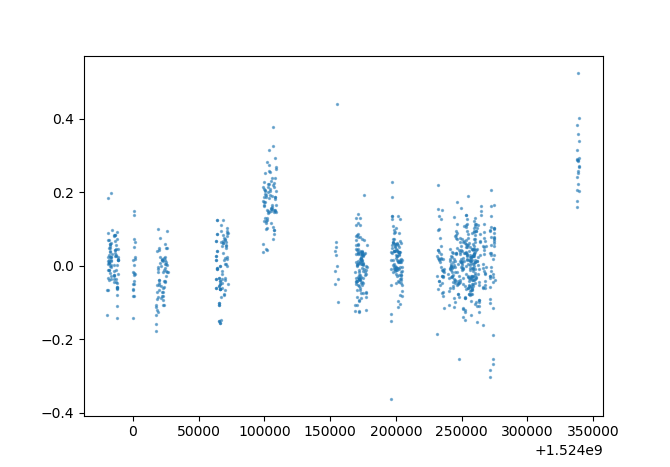

In [47]:
testing_list=[]
calibration_factor=12.0
for i in range(0,len(data[keylist[4]])):
    try:
        testing_list.append(data[keylist[4]][i]['error_x']/calibration_factor)
    except:
        print i
        testing_list.append(np.nan)

fig, ax = plt.subplots()
plt.scatter(data['timestamp_iteration'],testing_list,alpha=0.5,s=2)
plt.show()


C:\Anaconda2\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


<IPython.core.display.Javascript object>


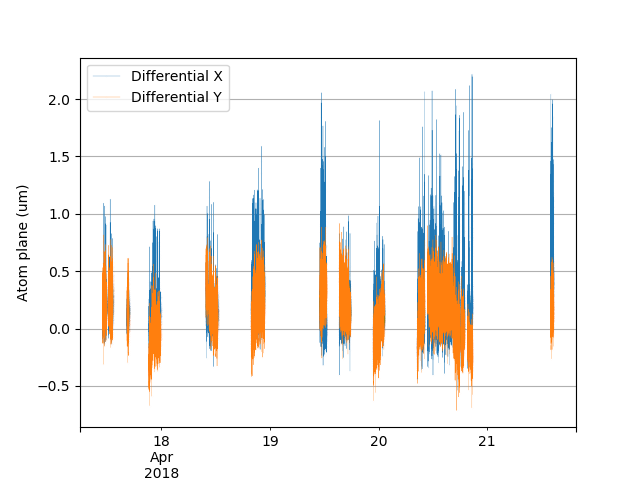

In [50]:
# Using Pandas
import pandas as pd
savefig=False
data_cutoff=0
flattendedtimestamps=np.array(flatten(data['timestamp_measurements']))
dates=[dt.datetime.fromtimestamp(ts) for ts in flattendedtimestamps][data_cutoff:]

flatteneddata0=np.array(flatten(data[keylist[0]]))[data_cutoff:]
flatteneddata2=np.array(flatten(data[keylist[2]]))[data_cutoff:]
flatteneddata1=np.array(flatten(data[keylist[1]]))[data_cutoff:]
flatteneddata3=np.array(flatten(data[keylist[3]]))[data_cutoff:]

samplerate='1S'
offsetX=(flatteneddata0-flatteneddata2)[0]
offsetY=(flatteneddata1-flatteneddata3)[0]
df=pd.DataFrame({'Differential X': flatteneddata0-flatteneddata2-offsetX,
                 'Differential Y': flatteneddata1-flatteneddata3-offsetY,
                 'Red X': flatteneddata0,
                 'Red Y': flatteneddata1,
                 'FORT X': flatteneddata2,
                 'FORT Y': flatteneddata3
                },index=dates)

## 
data_to_plot2=df.resample(samplerate).mean()
ax=data_to_plot2.plot(y=['Differential X','Differential Y'],lw=0.2,marker='.',markersize=0.02)
#data_to_plot2.plot(y='Differential Y',lw=0.2)
#ax.set_xlabel('Atom plane (um)')
ax.set_ylabel('Atom plane (um)')
ax.grid()
ax.legend()
plt.savefig('Alignment_20180415.png')

In [8]:
data_to_plot2

,Differential X,Differential Y
2018-04-15 12:24:00,0.033436,-0.086155
2018-04-15 12:24:10,0.096204,0.154932
2018-04-15 12:24:20,0.095273,0.180056
2018-04-15 12:24:30,0.098937,0.126298
2018-04-15 12:24:40,0.109810,0.174550
2018-04-15 12:24:50,0.130673,0.216353
2018-04-15 12:25:00,0.015736,0.119034
2018-04-15 12:25:10,0.032584,0.134498
2018-04-15 12:25:20,0.030223,0.127938
2018-04-15 12:25:30,0.055167,0.133412


In [51]:
# Allan 
tau_list=range(1,100)+range(101,1001,10)+range(1002,10002,100)+range(10003,100003,1000)
samplerates=[]
for i in tau_list:
    samplerates.append('{}S'.format(i))
        
samplerate='1S'

var_list={}

original_resampled=df.resample(samplerate).mean()

for i in range(0,len(tau_list)):
    avg_samplerate=samplerates[i]
    tau=tau_list[i]
    #print i
    try:
        downsampled=df.resample(avg_samplerate).mean() # Takes block-average for given time chuck size
        for key in downsampled:
            values=downsampled[key].values
            Xtau=values[1:]
            Xo=values[0:-1]
            var=np.nanmean(np.abs(Xtau-Xo))
            if i==0:
                var_list[key]=[]
            var_list[key].append(var)
    except:
        pass

<IPython.core.display.Javascript object>


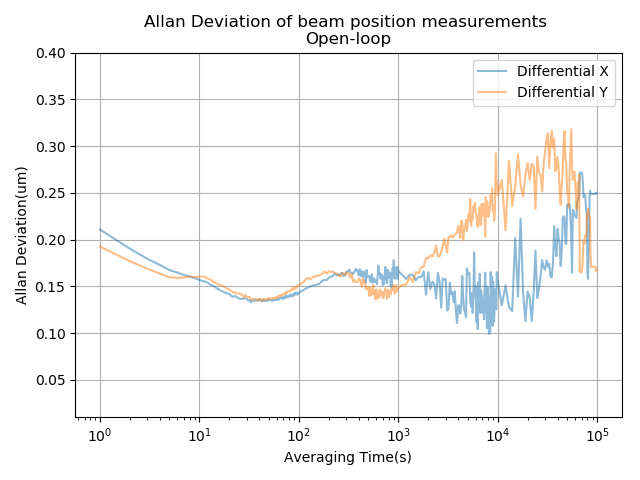

In [52]:
savefig=False
fig, ax = plt.subplots()
#xdata=tau_lists
#for key in var_list:
for key in ['Differential X','Differential Y']:
    ax.semilogx(tau_list, np.sqrt(0.5*np.array(var_list[key])),label=key,alpha=0.5)
#ax.semilogx(tau_list, np.sqrt(Yvar_list),label='Diff X',alpha=0.5)
# ax.plot(xdata,np.sqrt(Xvariance_list),label='Diff X',alpha=0.5)
# ax.plot(xdata,np.sqrt(Yvariance_list),label='Diff Y',alpha=0.5)
ax.legend()
#ax.set_xlim(1,)
ax.set_title('Allan Deviation of beam position measurements \nOpen-loop')
ax.set_xlabel('Averaging Time(s)')
ax.set_ylabel('Allan Deviation(um)')
#ax.axvline(x=60,color='k',alpha=0.3)
ax.set_ylim(0.01,0.4)
ax.grid()
plt.tight_layout()
if savefig:
    plt.savefig('AllanDeviation_Openloop.png')
    plt.savefig('AllanDeviation_Openloop.pdf')